In [ ]:
import pandas as pd
import numpy as np
import os
import re
from time import time

In [ ]:
import gensim
import keras
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder

np.random.seed(1003)

In [ ]:
# Specify the folder locations
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
DATA_DIR = ''
Glove = 'glove.6B.200d.txt'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 170
MAX_VOCAB_SIZE = 400000
LSTM_DIM = 128
EMBEDDING_DIM = 300
BATCH_SIZE = 200
N_EPOCHS = 10


In [ ]:
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')

In [ ]:
train['Stance'].replace('unrelated',1,True)
train['Stance'].replace('agree',2,True)
train['Stance'].replace('disagree',3,True)
train['Stance'].replace('discuss',4,True)

word_seq_headline_train = [text_to_word_sequence(sent) for sent in train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(sent) for sent in train['articleBody']]

word_seq_headline_test = [text_to_word_sequence(sent) for sent in test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(sent) for sent in test['articleBody']]

In [ ]:
word_seq = []
word_seq.extend(word_seq_headline_train)
word_seq.extend(word_seq_bodies_train)
word_seq.extend(word_seq_headline_test)
word_seq.extend(word_seq_bodies_test)


In [ ]:
for i in range (len(word_seq_headline_train)):
  word_seq_headline_train[i].extend(word_seq_bodies_train[i])


for i in range (len(word_seq_headline_test)):
  word_seq_headline_test[i].extend(word_seq_bodies_test[i])

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

In [ ]:
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = train['Stance']
y_train = y_train.values

In [ ]:
from keras.utils import np_utils

encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)


In [ ]:
EMBEDDING_DIM = 300
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [ ]:
X_train.shape

(44974, 170)

In [ ]:
#convolutional model 
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout

model_1 = Sequential()

model_1.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer' 
                          ))

model_1.add(Dropout(0.2))
model_1.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_1.add(BatchNormalization())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(4, activation='softmax'))

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())
# history1 = model_1.fit(X_train, y_train, epochs=5,validation_data=(X_val, y_val),batch_size=512,verbose=1)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         6714300   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          48032     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)              

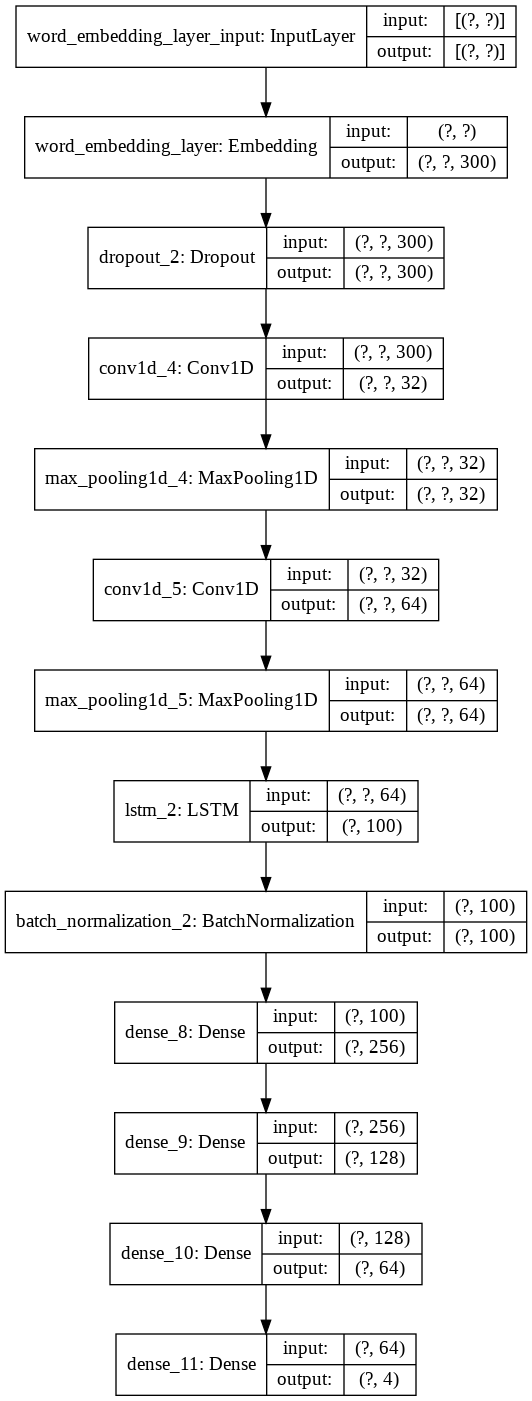

In [ ]:
from keras.utils import plot_model
plot_model(model_1, to_file='conv.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model_1.fit(X_train, y_train, epochs=5,validation_data=(X_val, y_val),batch_size=512,verbose=1)

Epoch 1/5
88/88 [==============================] - 166s 2s/step - loss: 0.2601 - accuracy: 0.7854 - val_loss: 0.2694 - val_accuracy: 0.7717
Epoch 2/5
88/88 [==============================] - 164s 2s/step - loss: 0.2405 - accuracy: 0.8020 - val_loss: 0.2546 - val_accuracy: 0.7861
Epoch 3/5
88/88 [==============================] - 165s 2s/step - loss: 0.2278 - accuracy: 0.8163 - val_loss: 0.2525 - val_accuracy: 0.7993
Epoch 4/5
88/88 [==============================] - 165s 2s/step - loss: 0.2172 - accuracy: 0.8254 - val_loss: 0.2712 - val_accuracy: 0.7791
Epoch 5/5
88/88 [==============================] - 165s 2s/step - loss: 0.2081 - accuracy: 0.8341 - val_loss: 0.2620 - val_accuracy: 0.7865


In [ ]:
from keras.models import load_model

model_1.save('conv1D_model.h5')

In [ ]:
#model Bidirectional with GRU 
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, GRU
# Build a sequential model by stacking neural net units - model 1 
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer' 
                          ))
model_2.add(Bidirectional(GRU(75),name='GRU layer'))

model_2.add(Dropout(0.8))
model_2.add(Dense(4, activation='sigmoid'))


In [ ]:
print (model_2.summary())

In [ ]:
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model_2.fit(X_train, y_train, epochs=5,validation_data=(X_val, y_val),batch_size=32,verbose=1)

Epoch 1/5
1406/1406 [==============================] - 622s 442ms/step - loss: 0.5952 - accuracy: 0.7791 - val_loss: 0.4467 - val_accuracy: 0.8311
Epoch 2/5
1406/1406 [==============================] - 604s 430ms/step - loss: 0.3459 - accuracy: 0.8607 - val_loss: 0.3145 - val_accuracy: 0.8705
Epoch 3/5
1406/1406 [==============================] - 608s 432ms/step - loss: 0.2089 - accuracy: 0.9136 - val_loss: 0.2541 - val_accuracy: 0.9020
Epoch 4/5
1406/1406 [==============================] - 570s 405ms/step - loss: 0.1297 - accuracy: 0.9490 - val_loss: 0.2091 - val_accuracy: 0.9262
Epoch 5/5
1406/1406 [==============================] - 600s 427ms/step - loss: 0.0885 - accuracy: 0.9665 - val_loss: 0.1911 - val_accuracy: 0.9346


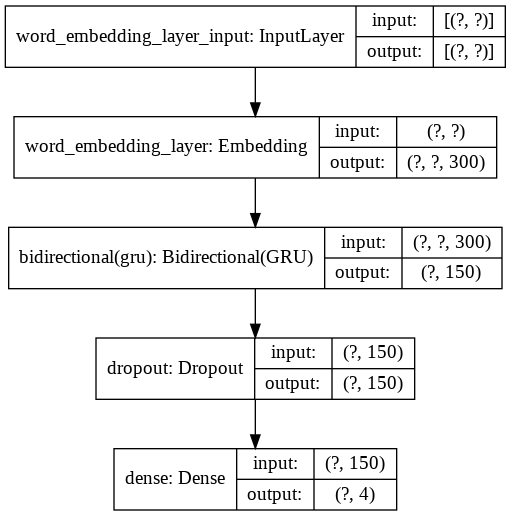

In [ ]:
from keras.utils import plot_model
plot_model(model_2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.models import load_model

model_2.save('/content/drive/My Drive/University of Waterloo/Spring 2020 /MSCI 641/Project /new_gru_scorer_final_model.h5')

In [ ]:
#Feed Forward Neural network 
model_3 = Sequential()
model_3.add(Dense(16, input_dim=170, activation="relu"))
model_3.add(Dense(12, activation="relu"))
model_3.add(Dense(4, activation="softmax"))

In [ ]:
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model_3.fit(X_train, y_train, epochs=5,validation_data=(X_val, y_val),batch_size=512,verbose=1)


Epoch 1/5
88/88 [==============================] - 0s 4ms/step - loss: 312.0505 - accuracy: 0.6069 - val_loss: 11.3975 - val_accuracy: 0.7145
Epoch 2/5
88/88 [==============================] - 0s 2ms/step - loss: 5.9838 - accuracy: 0.7225 - val_loss: 3.3597 - val_accuracy: 0.7235
Epoch 3/5
88/88 [==============================] - 0s 2ms/step - loss: 2.7886 - accuracy: 0.7282 - val_loss: 2.2142 - val_accuracy: 0.7261
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 1.9491 - accuracy: 0.7296 - val_loss: 1.6623 - val_accuracy: 0.7277
Epoch 5/5
88/88 [==============================] - 0s 2ms/step - loss: 1.5254 - accuracy: 0.7306 - val_loss: 1.4062 - val_accuracy: 0.7281


In [ ]:
model_3.save('/content/drive/My Drive/University of Waterloo/Spring 2020 /MSCI 641/Project /mlp_model.h5')

In [ ]:
competetion_bodies = pd.read_csv('/content/drive/My Drive/University of Waterloo/Spring 2020 /MSCI 641/Project /competition_test_bodies.csv')
competetion_stances = pd.read_csv('/content/drive/My Drive/University of Waterloo/Spring 2020 /MSCI 641/Project /competition_test_stances.csv')

competetion_unlabeled = pd.read_csv('/content/drive/My Drive/University of Waterloo/Spring 2020 /MSCI 641/Project /competition_test_stances_unlabeled.csv')

comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')


In [ ]:
comp.replace('unrelated',1,True)
comp.replace('agree',2,True)
comp.replace('disagree',3,True)
comp.replace('discuss',4,True)

In [ ]:
word_seq_headline_comp = [text_to_word_sequence(sent) for sent in comp['Headline']]
word_seq_bodies_comp = [text_to_word_sequence(sent) for sent in comp['articleBody']]


In [ ]:
for i in range (len(word_seq_headline_comp)):
  word_seq_headline_comp[i].extend(word_seq_bodies_comp[i])

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])


In [ ]:

X_comp = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])
X_comp = pad_sequences(X_comp, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_comp = comp['Stance']
y_comp = y_comp.values



In [ ]:
encoder_comp = LabelEncoder()
encoder_comp.fit(y_comp)
encoded_comp = encoder_comp.transform(y_comp)
dummy_y_comp = np_utils.to_categorical(encoded_comp)

In [ ]:
y_conv = model_1.predict(X_comp)
score,test_acc_conv_model = model_1.evaluate(X_comp, dummy_y_comp)

795/795 [==============================] - 23s 28ms/step - loss: 0.6497 - accuracy: 0.4460


In [ ]:
y_ = model_2.predict(X_comp)
score,test_acc = model_2.evaluate(X_comp, dummy_y_comp)


795/795 [==============================] - 57s 71ms/step - loss: 1.2102 - accuracy: 0.6935


In [ ]:
y_mlp= model_3.predict(X_comp)
score,test_acc_conv_model = model_3.evaluate(X_comp, dummy_y_comp)

795/795 [==============================] - 1s 941us/step - loss: 1.4070 - accuracy: 0.7200


In [ ]:
test_acc

0.6935033202171326

In [1]:
y_predict = model_2.predict(x=X_comp)
outputs = [np.argmax(p) for p in y_predict]
for i in range(len(outputs)):
  if outputs[i] == 0: outputs[i] = "agree"
  if outputs[i] == 1: outputs[i] = "disagree"
  if outputs[i] == 2: outputs[i] = "discuss"
  if outputs[i] == 3: outputs[i] = "unrelated"
print("Scores on the test set")
from utils.score import report_score
report_score(comp.Stance.values,outputs)


In [ ]:
test_accuracy 

0.7220320105552673